<a href="https://colab.research.google.com/github/Yogitasoni1708/2d-drawin-python-/blob/main/AI_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract opencv-python pillow nltk

import cv2
import pytesseract
import numpy as np
from PIL import Image
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def deskew_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    deskewed = cv2.warpAffine(image, M, (w, h),
                              flags=cv2.INTER_CUBIC,
                              borderMode=cv2.BORDER_REPLICATE)
    return deskewed

In [ ]:
def preprocess(img_path):
    img = cv2.imread(img_path)

    img = deskew_image(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return img, thresh

In [ ]:
def extract_text(processed_image):
    text = pytesseract.image_to_string(processed_image)
    return text

In [ ]:
def clean_text(text):
    text = text.encode("ascii", "ignore").decode()
    text = re.sub(r"[^\w\s@./-]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [ ]:
def detect_pii(text):
    pii = {}

    pii["email"] = re.findall(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", text)
    pii["phone"] = re.findall(r"\b[6-9]\d{9}\b", text)
    pii["date"] = re.findall(r"\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b", text)
    pii["aadhaar"] = re.findall(r"\b\d{4}\s\d{4}\s\d{4}\b", text)
    pii["pan"] = re.findall(r"\b[A-Z]{5}\d{4}[A-Z]\b", text)

    # Simple name detection: sequences of capitalized words
    pii["name"] = re.findall(r"\b[A-Z][a-z]+ [A-Z][a-z]+\b", text)

    return pii

In [ ]:
def redact_image(img_path, text, pii_list):
    img = cv2.imread(img_path)
    boxes = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    for i, w in enumerate(boxes['text']):
        for item in pii_list:
            if item in w:
                x, y, bw, bh = boxes['left'][i], boxes['top'][i], boxes['width'][i], boxes['height'][i]
                cv2.rectangle(img, (x, y), (x + bw, y + bh), (0, 0, 0), -1)

    cv2.imwrite("redacted_output.jpg", img)
    return img

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving page_14.jpg_page-0001.jpg to page_14.jpg_page-0001.jpg


In [ ]:
img_path = "page_14.jpg_page-0001.jpg"

original, processed = preprocess(img_path)
text_raw = extract_text(processed)
cleaned = clean_text(text_raw)
pii = detect_pii(cleaned)

print("----- Extracted Text -----")
print(cleaned)

print("\n----- PII Detected -----")
print(pii)

----- Extracted Text -----
ss al . ti ra A 7 xab9

----- PII Detected -----
{'email': [], 'phone': [], 'date': [], 'aadhaar': [], 'pan': [], 'name': []}


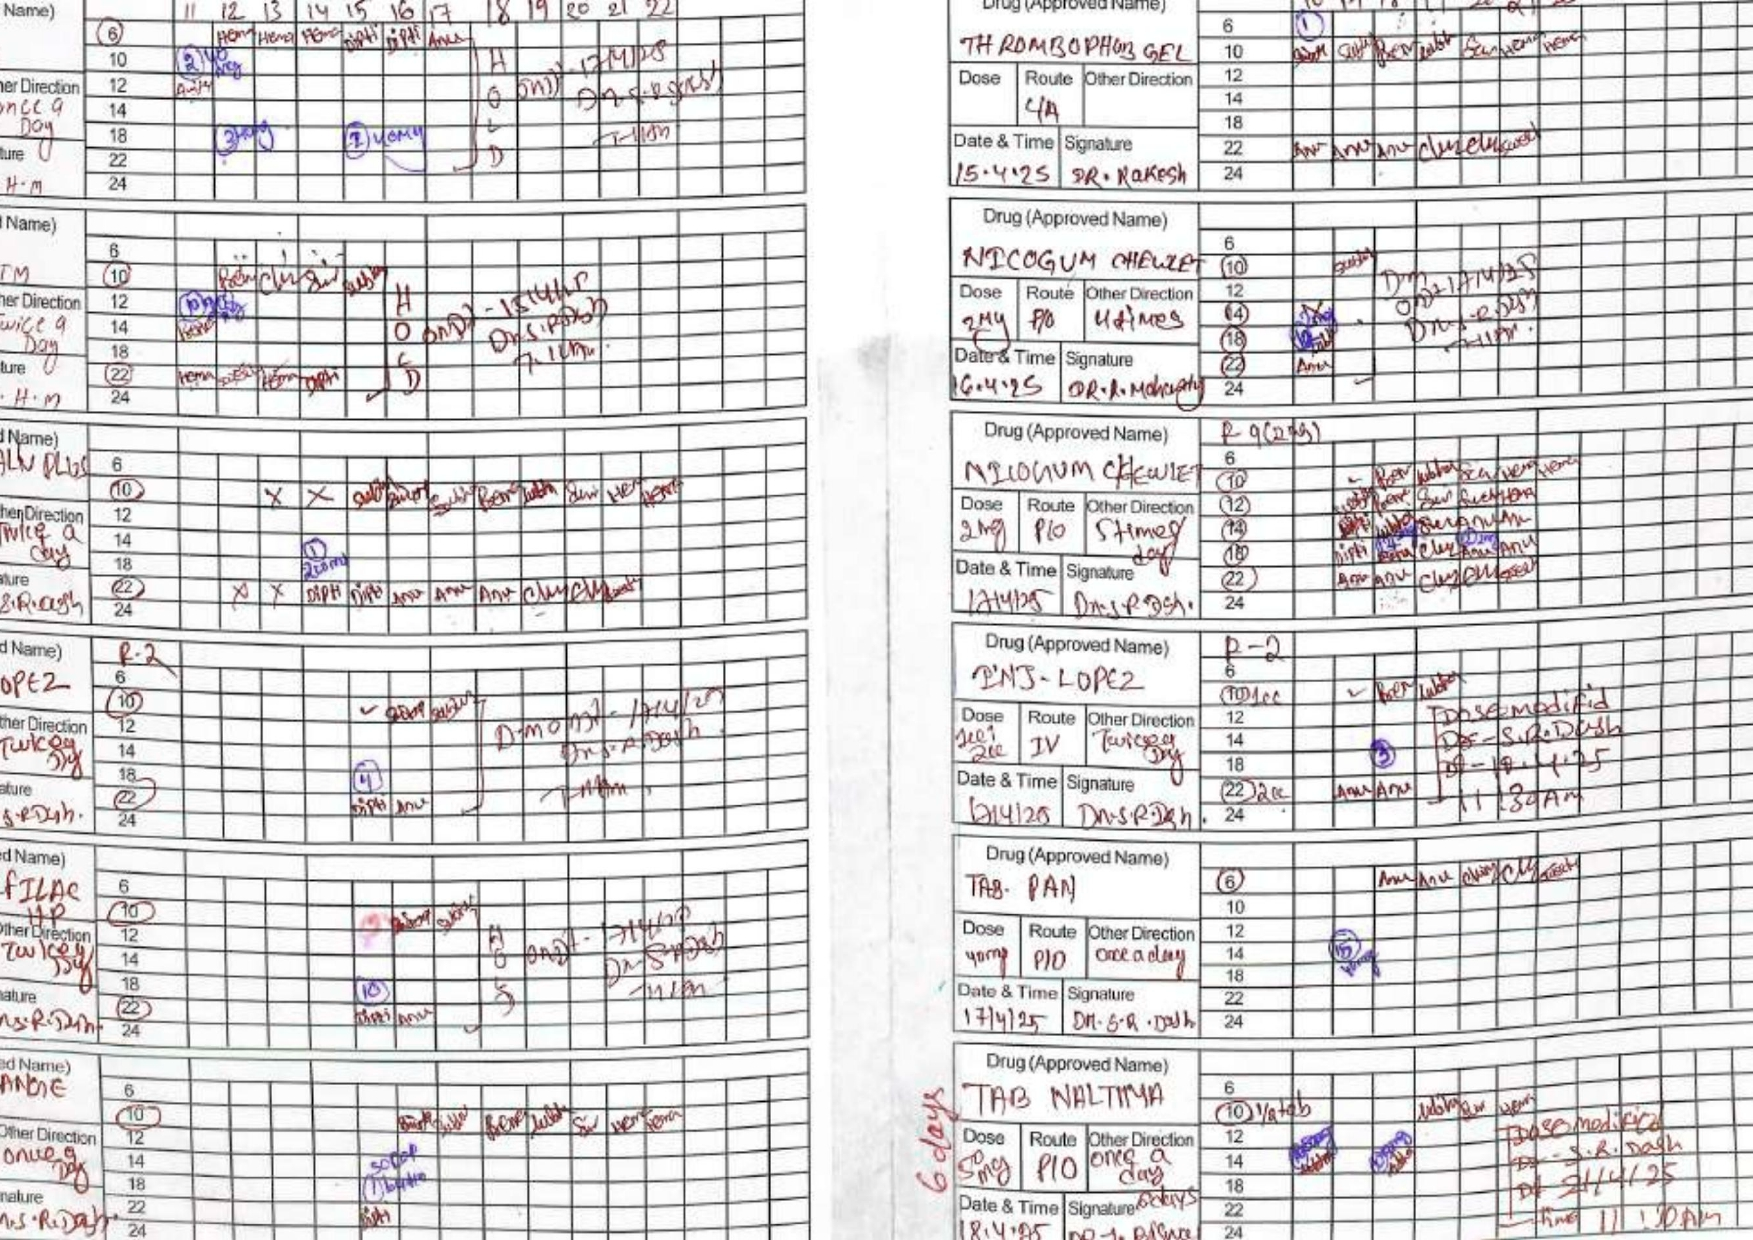

In [ ]:
all_pii = sum(pii.values(), [])
redacted_img = redact_image(img_path, cleaned, all_pii)
Image.fromarray(redacted_img)